In [1]:
import torch, gc
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
import sys
sys.path.append(r"C:\Users\suxin\PycharmProjects\pythonProject")
from AutoAugment import ImageNetPolicy

In [3]:
transform_train = transforms.Compose([
# 对原始32*32图像四周各填充4个0像素（40*40），然后随机裁剪成32*32
#transforms.RandomCrop(32, padding=4),
# transforms.RandomResizedCrop(224),
# 按0.5的概率水平翻转图片
#transforms.RandomHorizontalFlip(),
ImageNetPolicy(),
#transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


transform_test = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


trainingdata = torchvision.datasets.CIFAR10('./CIFAR10/',train=True,download=True,transform=transform_train)
testdata = torchvision.datasets.CIFAR10('./CIFAR10/',train=False,download=True,transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=128,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=128,shuffle=False)

In [5]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv1_dropout = nn.Dropout2d(p=0.5)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2_dropout = nn.Dropout2d(p=0.5)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.conv1_dropout(out)
        out = self.bn2(self.conv2(out))
        out = self.conv2_dropout(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
#         self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(256, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project1_model():
    return ResNet(BasicBlock, [3,6,4,3])

net = project1_model().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(net)

4883626

In [7]:
def calculate_accu():
    return (torch.eq(torch.max(predicted_output, 1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()

In [8]:
train_loss_history = []
test_loss_history = []
accuracy_history = []

for epoch in range(150):
    train_loss = 0.0
    test_loss = 0.0
    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = net(images)
        fit = Loss(predicted_output,labels)
        fit.backward()
        optimizer.step()
        train_loss += fit.item()
    for i, data in enumerate(testDataLoader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        predicted_output = net(images)
        fit = Loss(predicted_output,labels)
        test_loss += fit.item()
    scheduler.step()
    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    accuracy = calculate_accu()
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    accuracy_history.append(calculate_accu())
    print('Epoch %s, Train loss %s, Test loss %s, accuracy %s'%(epoch, train_loss, test_loss, accuracy), "%")

Epoch 0, Train loss 2.3897583698067826, Test loss 2.2841192076477825, accuracy 12.5 %
Epoch 1, Train loss 2.259875908532106, Test loss 2.083724273911005, accuracy 18.75 %
Epoch 2, Train loss 2.1570099339155893, Test loss 1.9328666080402424, accuracy 12.5 %
Epoch 3, Train loss 2.0253156850405056, Test loss 1.7877558499951907, accuracy 12.5 %
Epoch 4, Train loss 1.8973208696336088, Test loss 1.612214856509921, accuracy 50.0 %
Epoch 5, Train loss 1.7576053160840592, Test loss 1.5164270959322965, accuracy 62.5 %
Epoch 6, Train loss 1.6204329814447467, Test loss 1.3457864507844177, accuracy 56.25 %
Epoch 7, Train loss 1.5116971276910103, Test loss 1.257725282560421, accuracy 62.5 %
Epoch 8, Train loss 1.4288743917289597, Test loss 1.179769753655301, accuracy 50.0 %
Epoch 9, Train loss 1.370121762880584, Test loss 1.1360615069353128, accuracy 68.75 %
Epoch 10, Train loss 1.3179819791213325, Test loss 1.103016379513318, accuracy 68.75 %
Epoch 11, Train loss 1.272003652037257, Test loss 1.0473

Epoch 95, Train loss 0.5288091974947459, Test loss 0.561106334004221, accuracy 87.5 %
Epoch 96, Train loss 0.5210220800793689, Test loss 0.5640591647051558, accuracy 87.5 %
Epoch 97, Train loss 0.527639614346692, Test loss 0.5632127851625032, accuracy 87.5 %
Epoch 98, Train loss 0.5235541756348232, Test loss 0.5554822238185738, accuracy 93.75 %
Epoch 99, Train loss 0.5240547772868515, Test loss 0.5483283193051061, accuracy 81.25 %
Epoch 100, Train loss 0.516079192957305, Test loss 0.5549218926248671, accuracy 87.5 %
Epoch 101, Train loss 0.5146222052061954, Test loss 0.5697351762011081, accuracy 81.25 %
Epoch 102, Train loss 0.5180534416299951, Test loss 0.5483839470374433, accuracy 81.25 %
Epoch 103, Train loss 0.5097382022139362, Test loss 0.5604831240599668, accuracy 68.75 %
Epoch 104, Train loss 0.517737773678187, Test loss 0.5449087144453314, accuracy 93.75 %
Epoch 105, Train loss 0.5135015179891416, Test loss 0.5512630550921718, accuracy 81.25 %
Epoch 106, Train loss 0.5158007629

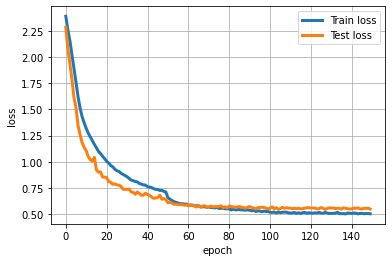

In [9]:
import matplotlib.pyplot as plt
plt.plot(range(150),train_loss_history,'-',linewidth=3,label='Train loss')
plt.plot(range(150),test_loss_history,'-',linewidth=3,label='Test loss')
# plt.plot(range(100),accuracy,'-',linewidth=3,label='Accuracy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [10]:
print("Accuracy: ", 
(torch.eq(torch.max(predicted_output, 1) 
[1],labels).sum()/len(labels)*100).data.cpu().numpy(),"%")

Accuracy:  87.5 %


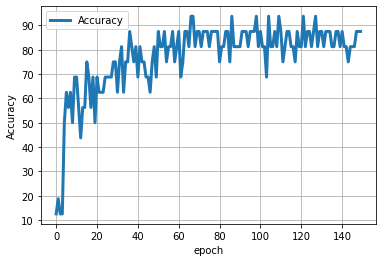

In [11]:
plt.plot(range(150),accuracy_history,'-',linewidth=3,label='Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

In [12]:
## save model
model_path = './project1_model.pt'
torch.save(net.state_dict(), model_path)